<a href="https://colab.research.google.com/github/lucianavmont/mirepo/blob/main/CNN_FGSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OCR model for reading Captchas

**Author:** [A_K_Nain](https://twitter.com/A_K_Nain)<br>
**Date created:** 2020/06/14<br>


In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
import keras
from keras import layers

In [ ]:
!curl -LO https://github.com/lucianavmont/mirepo/raw/main/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9231k  100 9231k    0     0  6784k      0  0:00:01  0:00:01 --:--:-- 68.1M


In [ ]:

data_dir = Path("./captcha_images_v2/")

images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Numero de caracteres unicos: ", len(characters))
print("Caracteres presentes: ", characters)

batch_size = 16

img_width = 200
img_height = 50

downsample_factor = 4

max_length = max([len(label) for label in labels])


Numero de caracteres unicos:  19
Caracteres presentes:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [ ]:


char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)


num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):

    size = len(images)

    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)

    train_samples = int(size * train_size)

    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):

    img = tf.io.read_file(img_path)

    img = tf.io.decode_png(img, channels=1)

    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, [img_height, img_width])

    img = tf.transpose(img, perm=[1, 0, 2])

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}


In [ ]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

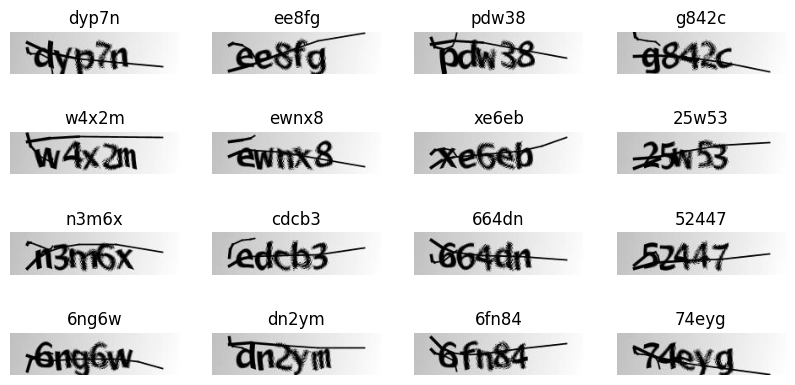

In [ ]:

_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Modelo


In [ ]:

def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), tf.int32)
    input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)
    sparse_labels = tf.cast(ctc_label_dense_to_sparse(y_true, label_length), tf.int32)

    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())

    return tf.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = tf.shape(labels)
    num_batches_tns = tf.stack([label_shape[0]])
    max_num_labels_tns = tf.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return tf.expand_dims(tf.range(tf.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = tf.cast(tf.fill([1, label_shape[1]], 0), tf.bool)
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = tf.reshape(
        tf.tile(tf.range(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = tf.transpose(
        tf.reshape(
            tf.tile(tf.range(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = tf.transpose(
        tf.reshape(tf.concat([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        tf.cast(indices, tf.int64), vals_sparse, tf.cast(label_shape, tf.int64)
    )


class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # primera capa
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Segunda capa
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    # Definir modelo
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizador
    opt = keras.optimizers.Adam()
    # Compilar
    model.compile(optimizer=opt)
    return model


# Modelo
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

## Entrenamiento

In [ ]:

epochs = 100
early_stopping_patience = 10
# early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Entrenar modelo
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/100
59/59 [==============================] - 23s 61ms/step - loss: 20.6394 - val_loss: 16.3815
Epoch 2/100
59/59 [==============================] - 2s 30ms/step - loss: 16.3722 - val_loss: 16.3431
Epoch 3/100
59/59 [==============================] - 2s 34ms/step - loss: 16.3666 - val_loss: 16.3422
Epoch 4/100
59/59 [==============================] - 2s 40ms/step - loss: 16.3537 - val_loss: 16.3443
Epoch 5/100
59/59 [==============================] - 2s 30ms/step - loss: 16.3494 - val_loss: 16.3511
Epoch 6/100
59/59 [==============================] - 2s 30ms/step - loss: 16.3384 - val_loss: 16.3511
Epoch 7/100
59/59 [==============================] - 2s 30ms/step - loss: 16.3345 - val_loss: 16.3182
Epoch 8/100
59/59 [==============================] - 2s 31ms/step - loss: 16.3234 - val_loss: 16.3080
Epoch 9/100
59/59 [==============================] - 3s 48ms/step - loss: 16.2999 - val_loss: 16.2633
Epoch 10/100
59/59 [==============================] - 2s 33ms/step - loss: 16.268

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

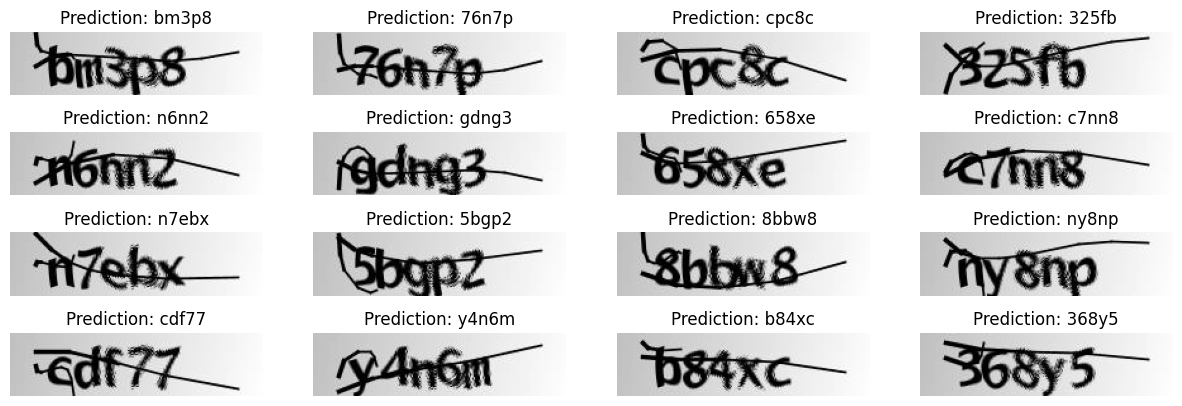

In [ ]:

def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = tf.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())
    input_length = tf.cast(input_length, tf.int32)

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)



prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)
prediction_model.summary()


def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]

    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
        # Imprimir el shape de la imagen de entrada y la predicción
    print(f"Shape de la imagen de entrada: {batch_images.shape}")
    print(f"Shape de la predicción: {preds.shape}")

    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()


Métricas de modelo

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import tensorflow as tf

def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = tf.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())
    input_length = tf.cast(input_length, dtype="int32")

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# Function to calculate cumulative accuracy for first n characters
def cumulative_char_accuracy(true_texts, pred_texts, max_length):
    cumulative_accuracies = []

    for n in range(1, max_length + 1):
        correct_counts = 0
        total_counts = 0

        for true, pred in zip(true_texts, pred_texts):
            true_sub = true[:n]
            pred_sub = pred[:n]

            if true_sub == pred_sub:
                correct_counts += 1
            total_counts += 1

        accuracy = correct_counts / total_counts if total_counts > 0 else 0
        cumulative_accuracies.append(accuracy)

    return cumulative_accuracies

# Evaluate the model on validation data and calculate metrics
def evaluate_model(model, validation_dataset):
    all_preds = []
    all_labels = []

    for batch in validation_dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        orig_texts = []
        for label in batch_labels:
            label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            orig_texts.append(label)

        all_preds.extend(pred_texts)
        all_labels.extend(orig_texts)

    # Calculate Accuracy (Recognition Rate)
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy (Recognition Rate): {accuracy * 100:.2f}%')

    # Calculate Error Rate
    error_rate = 1 - accuracy
    print(f'Error Rate: {error_rate * 100:.2f}%')

    # Calculate Cumulative Character Accuracy
    cumulative_accuracies = cumulative_char_accuracy(all_labels, all_preds, max_length)
    for i, acc in enumerate(cumulative_accuracies, 1):
        print(f'Cumulative Accuracy for first {i} characters: {acc * 100:.2f}%')

evaluate_model(prediction_model, validation_dataset)



1/1 [==============================] - 0s 22ms/step
Accuracy (Recognition Rate): 100.00%
Error Rate: 0.00%
Cumulative Accuracy for first 1 characters: 100.00%
Cumulative Accuracy for first 2 characters: 100.00%
Cumulative Accuracy for first 3 characters: 100.00%
Cumulative Accuracy for first 4 characters: 100.00%
Cumulative Accuracy for first 5 characters: 100.00%


# Aplicación de FGSM (0.01)

Código de aplicación

In [ ]:
import tensorflow as tf
import random

def ctc_loss_fn(y_true, y_pred, input_length, label_length):
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

def create_adversarial_pattern(model, input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model([input_image, input_label], training=True)
        input_length = tf.ones(shape=(input_image.shape[0], 1)) * prediction.shape[1]
        label_length = tf.ones(shape=(input_label.shape[0], 1)) * input_label.shape[1]
        loss = ctc_loss_fn(input_label, prediction, input_length, label_length)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

def apply_fgsm_to_dataset(model, dataset, epsilon=0.01):
    adversarial_images = []
    adversarial_labels = []

    for batch in dataset:
        images = batch["image"]
        labels = batch["label"]

        for i in range(images.shape[0]):
            image = tf.expand_dims(images[i], axis=0)
            label = tf.expand_dims(labels[i], axis=0)
            perturbations = create_adversarial_pattern(model, image, label)
            adversarial_image = image + epsilon * perturbations
            adversarial_images.append(tf.squeeze(adversarial_image))
            adversarial_labels.append(labels[i])

    return tf.stack(adversarial_images), tf.stack(adversarial_labels)

combined_dataset = train_dataset.concatenate(validation_dataset)
adversarial_images, adversarial_labels = apply_fgsm_to_dataset(model, combined_dataset)


Mostrar y guardar en carpeta

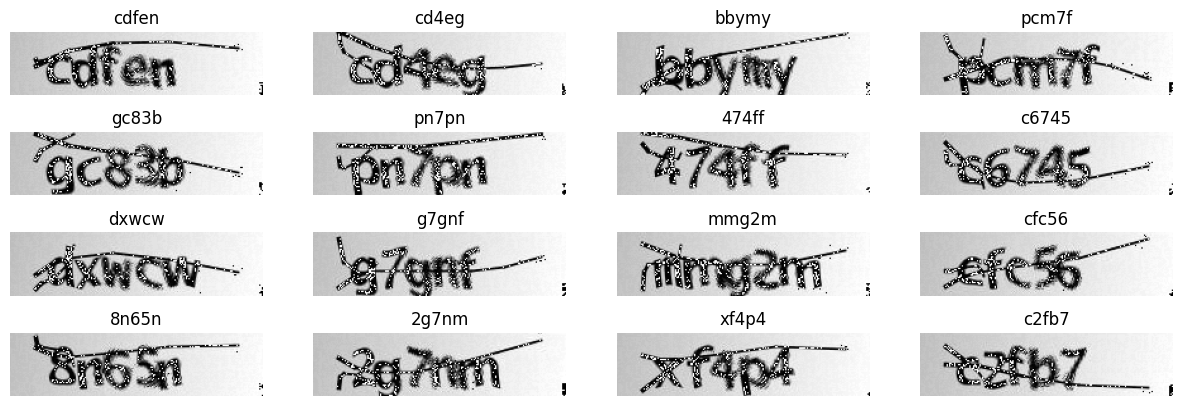

In [ ]:
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Crear un nuevo directorio para las imágenes adversariales
adversarial_dir = Path("./FGSM_001/")
adversarial_dir.mkdir(exist_ok=True)

# Guardar las imágenes adversariales sin el índice
for i, (img, label) in enumerate(zip(adversarial_images, adversarial_labels)):
    img = (img * 255).astype(np.uint8)
    if img.ndim == 2:  # Si la imagen es 2D (altura, ancho)
        img = np.expand_dims(img, axis=-1)  # Añadir la dimensión del canal
    # Rotar la imagen 90 grados en sentido antihorario y luego invertirla horizontalmente
    img = tf.image.rot90(img, k=3).numpy()  # k=3 para rotar 270 grados o -90 grados
    img = tf.image.flip_left_right(img).numpy()  # Invertir horizontalmente
    img = tf.image.encode_png(img).numpy()
    label_text = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    with open(adversarial_dir / f"{label_text}.png", "wb") as f:
        f.write(img)


# Visualizar ejemplos adversariales
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    img = (adversarial_images[i] * 255).astype(np.uint8)
    label = tf.strings.reduce_join(num_to_char(adversarial_labels[i])).numpy().decode("utf-8")
    if img.ndim == 2:  # Si la imagen es 2D (altura, ancho)
        img = np.expand_dims(img, axis=-1)  # Añadir la dimensión del canal
    # Rotar la imagen 90 grados en sentido antihorario y luego invertirla horizontalmente para la visualización
    img = tf.image.rot90(img, k=3).numpy()  # k=3 para rotar 270 grados o -90 grados
    img = tf.image.flip_left_right(img).numpy()  # Invertir horizontalmente
    ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")  # Mostrar la imagen sin transponer
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")
plt.show()




Predicción y métricas

65/65 [==============================] - 6s 86ms/step
Tasa de Reconocimiento (Recognition Rate): 0.00%
Tasa de Error (Error Rate): 100.00%
Accuracy acumulativo por 1 caracteres: 4.42%
Accuracy acumulativo por 2 caracteres: 0.58%
Accuracy acumulativo por 3 caracteres: 0.00%
Accuracy acumulativo por 4 caracteres: 0.00%
Accuracy acumulativo por 5 caracteres: 0.00%
Tasa de Suceso del Ataque (Attack Success Rate): 100.00%
Verdadero: jkmlp - Predicción: msm99
Verdadero: jkdln - Predicción: ttttm
Verdadero: iitot - Predicción: ttqm9
Verdadero: qjogm - Predicción: mtbtt
Verdadero: njhci - Predicción: tbmt9
Verdadero: qpgqp - Predicción: ttcgt
Verdadero: dgdmm - Predicción: bttg9
Verdadero: jfgde - Predicción: tttt9
Verdadero: ksrjr - Predicción: tbbtt
Verdadero: ngnpm - Predicción: tttm9


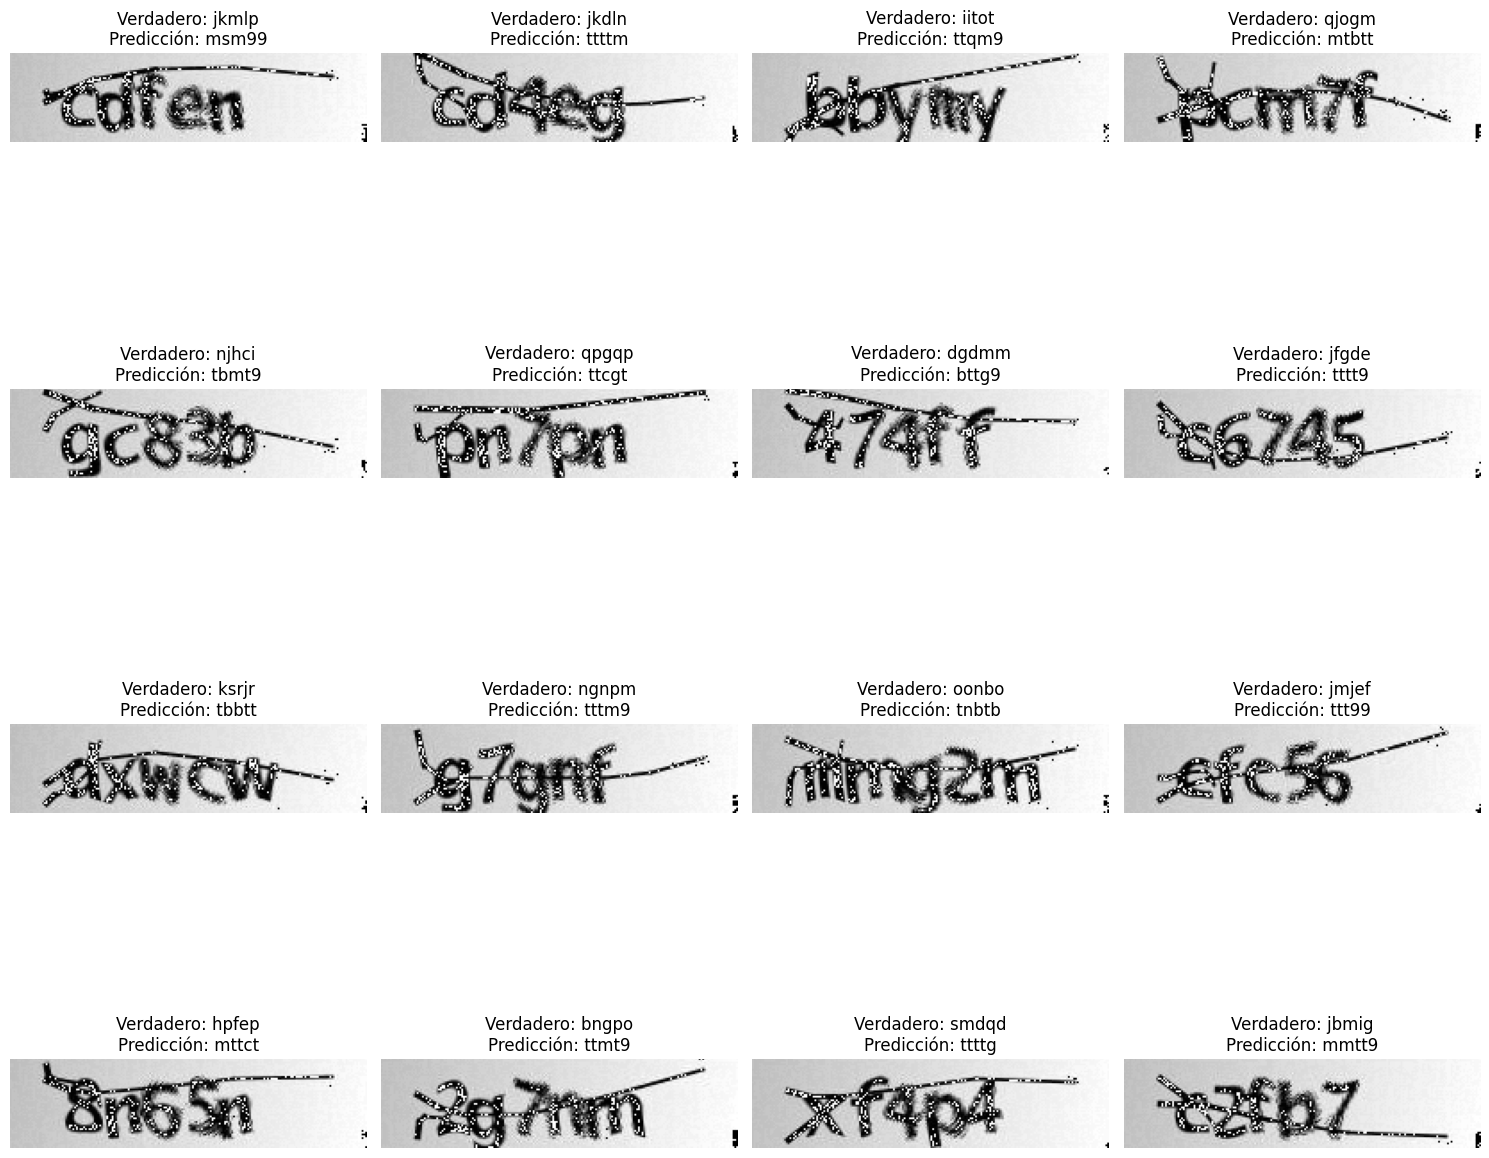

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Verifica que `num_to_char` esté bien definido
# Debe ser un mapeo correcto de índices a caracteres
def num_to_char(index):
    characters = "abcdefghijklmnopqrstuvwxyz0123456789"  # Ejemplo
    if index < len(characters):
        return characters[index]
    return ' '  # Reemplaza 'UNK' por espacio

# Función para preprocesar una imagen adversarial (girar 270 grados e invertir)
def preprocess_image(image):
    image = np.squeeze(image)
    if len(image.shape) == 2:  # Forma (height, width)
        image = np.expand_dims(image, axis=-1)  # Forma (height, width, 1)
    image = np.expand_dims(image, axis=0)  # Forma (1, height, width, channels)
    image = np.rot90(image, k=3, axes=(1, 2))
    image = np.flip(image, axis=2)
    return image

# Aplica el preprocesamiento a todas las imágenes
preprocessed_images = np.array([preprocess_image(img) for img in adversarial_images])

# Combina las imágenes preprocesadas de nuevo en un solo array
preprocessed_images = np.concatenate(preprocessed_images, axis=0)

# Función para decodificar las predicciones del modelo, limitando a 5 caracteres
def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for res in results:
        # Limita a 5 caracteres y reemplaza 'UNK' por espacio
        res = ''.join([num_to_char(idx) for idx in res[:5]])
        output_text.append(res)
    return output_text

# Evaluar el modelo en el conjunto de datos adversariales
predictions = prediction_model.predict(preprocessed_images, batch_size=batch_size)
decoded_predictions = decode_predictions(predictions)

# Obtener las etiquetas reales, limitadas a 5 caracteres
true_labels = [''.join([num_to_char(idx) for idx in label[:5]]) for label in adversarial_labels]

# Calcular la Tasa de Reconocimiento
correct_predictions = sum([1 for true, pred in zip(true_labels, decoded_predictions) if true == pred])
total_predictions = len(true_labels)
recognition_rate = correct_predictions / total_predictions
error_rate = 1 - recognition_rate

# Calcular el accuracy acumulativo por longitud de caracteres
cumulative_accuracy = {i: 0 for i in range(1, 6)}

for true, pred in zip(true_labels, decoded_predictions):
    for i in range(1, 6):
        if true[:i] == pred[:i]:
            cumulative_accuracy[i] += 1

cumulative_accuracy = {i: cumulative_accuracy[i] / total_predictions for i in cumulative_accuracy}

# Calcular la Tasa de Suceso del Ataque (Attack Success Rate)
attack_success_count = sum([1 for true, pred in zip(true_labels, decoded_predictions) if true != pred])
attack_success_rate = attack_success_count / total_predictions

# Mostrar los resultados
print(f"Tasa de Reconocimiento (Recognition Rate): {recognition_rate * 100:.2f}%")
print(f"Tasa de Error (Error Rate): {error_rate * 100:.2f}%")
for i in range(1, 6):
    print(f"Accuracy acumulativo por {i} caracteres: {cumulative_accuracy[i] * 100:.2f}%")
print(f"Tasa de Suceso del Ataque (Attack Success Rate): {attack_success_rate * 100:.2f}%")

# Mostrar algunas predicciones y las etiquetas verdaderas
for i in range(10):
    print(f"Verdadero: {true_labels[i]} - Predicción: {decoded_predictions[i]}")

# Visualizar ejemplos adversariales
_, ax = plt.subplots(4, 4, figsize=(15, 15))  # Ajustar el tamaño del gráfico
for i in range(16):
    img = (preprocessed_images[i] * 255).astype(np.uint8).squeeze()
    label = ''.join([num_to_char(idx) for idx in adversarial_labels[i][:5]])
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(f"Verdadero: {label}\nPredicción: {decoded_predictions[i]}")
    ax[i // 4, i % 4].axis("off")
plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
plt.show()


# Aplicación de técnica (0.05)

In [ ]:
import tensorflow as tf
import random

def ctc_loss_fn(y_true, y_pred, input_length, label_length):
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

def create_adversarial_pattern(model, input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model([input_image, input_label], training=True)
        input_length = tf.ones(shape=(input_image.shape[0], 1)) * prediction.shape[1]
        label_length = tf.ones(shape=(input_label.shape[0], 1)) * input_label.shape[1]
        loss = ctc_loss_fn(input_label, prediction, input_length, label_length)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

def apply_fgsm_to_dataset(model, dataset, epsilon=0.05):
    adversarial_images = []
    adversarial_labels = []

    for batch in dataset:
        images = batch["image"]
        labels = batch["label"]

        for i in range(images.shape[0]):
            image = tf.expand_dims(images[i], axis=0)
            label = tf.expand_dims(labels[i], axis=0)
            perturbations = create_adversarial_pattern(model, image, label)
            adversarial_image = image + epsilon * perturbations
            adversarial_images.append(tf.squeeze(adversarial_image))
            adversarial_labels.append(labels[i])

    return tf.stack(adversarial_images), tf.stack(adversarial_labels)

combined_dataset = train_dataset.concatenate(validation_dataset)
adversarial_images, adversarial_labels = apply_fgsm_to_dataset(model, combined_dataset)

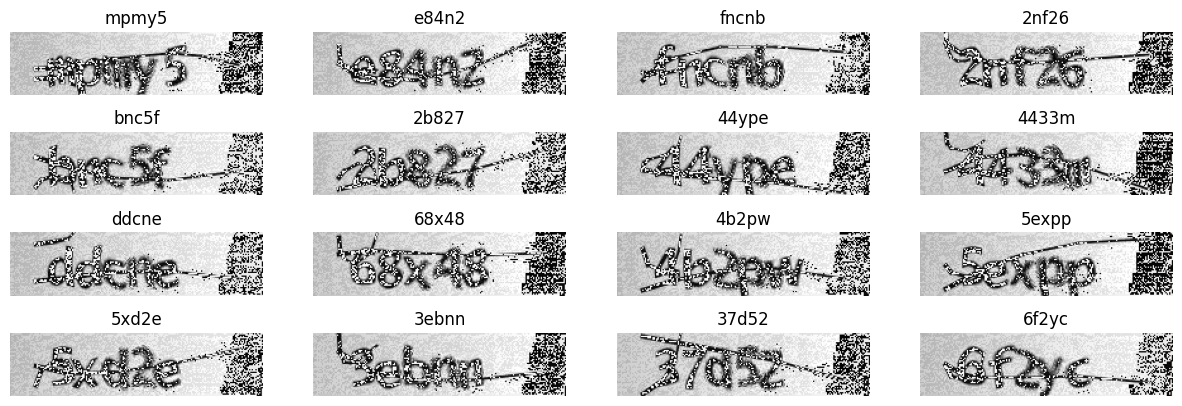

In [ ]:
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Crear un nuevo directorio para las imágenes adversariales
adversarial_dir = Path("./FGSM_005/")
adversarial_dir.mkdir(exist_ok=True)

# Guardar las imágenes adversariales sin el índice
for i, (img, label) in enumerate(zip(adversarial_images, adversarial_labels)):
    img = (img * 255).numpy().astype(np.uint8)
    if img.ndim == 2:  # Si la imagen es 2D (altura, ancho)
        img = np.expand_dims(img, axis=-1)  # Añadir la dimensión del canal
    # Rotar la imagen 90 grados en sentido antihorario y luego invertirla horizontalmente
    img = tf.image.rot90(img, k=3).numpy()  # k=3 para rotar 270 grados o -90 grados
    img = tf.image.flip_left_right(img).numpy()  # Invertir horizontalmente
    img = tf.image.encode_png(img).numpy()
    label_text = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    with open(adversarial_dir / f"{label_text}.png", "wb") as f:
        f.write(img)


# Visualizar ejemplos adversariales
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    img = (adversarial_images[i] * 255).numpy().astype(np.uint8)
    label = tf.strings.reduce_join(num_to_char(adversarial_labels[i])).numpy().decode("utf-8")
    if img.ndim == 2:  # Si la imagen es 2D (altura, ancho)
        img = np.expand_dims(img, axis=-1)  # Añadir la dimensión del canal
    # Rotar la imagen 90 grados en sentido antihorario y luego invertirla horizontalmente para la visualización
    img = tf.image.rot90(img, k=3).numpy()  # k=3 para rotar 270 grados o -90 grados
    img = tf.image.flip_left_right(img).numpy()  # Invertir horizontalmente
    ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")  # Mostrar la imagen sin transponer
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")
plt.show()


65/65 [==============================] - 4s 11ms/step
Tasa de Reconocimiento (Recognition Rate): 0.00%
Tasa de Error (Error Rate): 100.00%
Accuracy acumulativo por 1 caracteres: 5.00%
Accuracy acumulativo por 2 caracteres: 0.10%
Accuracy acumulativo por 3 caracteres: 0.00%
Accuracy acumulativo por 4 caracteres: 0.00%
Accuracy acumulativo por 5 caracteres: 0.00%
Tasa de Suceso del Ataque (Attack Success Rate): 100.00%
Verdadero: oqote - Predicción: mgt99
Verdadero: lhdpb - Predicción: ttt99
Verdadero: mpjpi - Predicción: tttt9
Verdadero: bpmbf - Predicción: tt999
Verdadero: ipjem - Predicción: tgt99
Verdadero: bihbg - Predicción: cgm99
Verdadero: ddtql - Predicción: tttt9
Verdadero: ddcco - Predicción: ttdm9
Verdadero: kkjpl - Predicción: tt999
Verdadero: fhsdh - Predicción: tt999


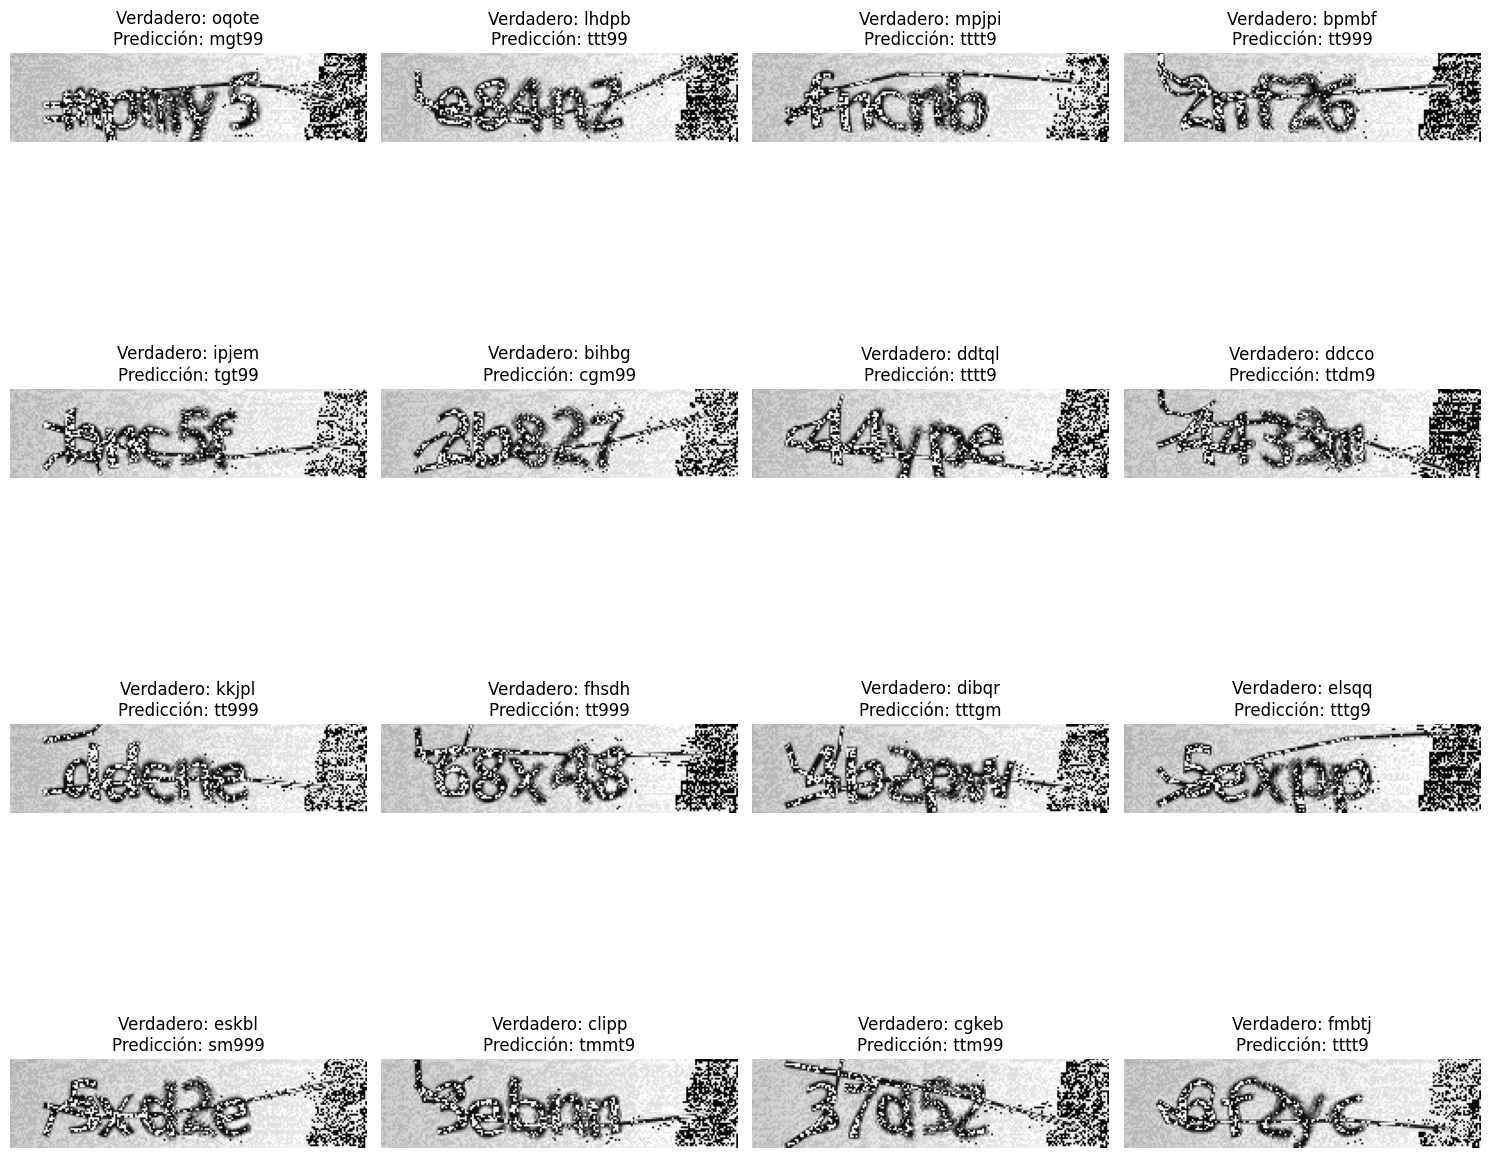

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Verifica que `num_to_char` esté bien definido
# Debe ser un mapeo correcto de índices a caracteres
def num_to_char(index):
    characters = "abcdefghijklmnopqrstuvwxyz0123456789"  # Ejemplo
    if index < len(characters):
        return characters[index]
    return ' '  # Reemplaza 'UNK' por espacio

# Función para preprocesar una imagen adversarial (girar 270 grados e invertir)
def preprocess_image(image):
    image = np.squeeze(image)
    if len(image.shape) == 2:  # Forma (height, width)
        image = np.expand_dims(image, axis=-1)  # Forma (height, width, 1)
    image = np.expand_dims(image, axis=0)  # Forma (1, height, width, channels)
    image = np.rot90(image, k=3, axes=(1, 2))
    image = np.flip(image, axis=2)
    return image

# Aplica el preprocesamiento a todas las imágenes
preprocessed_images = np.array([preprocess_image(img) for img in adversarial_images])

# Combina las imágenes preprocesadas de nuevo en un solo array
preprocessed_images = np.concatenate(preprocessed_images, axis=0)

# Función para decodificar las predicciones del modelo, limitando a 5 caracteres
def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for res in results:
        # Limita a 5 caracteres y reemplaza 'UNK' por espacio
        res = ''.join([num_to_char(idx) for idx in res[:5]])
        output_text.append(res)
    return output_text

# Evaluar el modelo en el conjunto de datos adversariales
predictions = prediction_model.predict(preprocessed_images, batch_size=batch_size)
decoded_predictions = decode_predictions(predictions)

# Obtener las etiquetas reales, limitadas a 5 caracteres
true_labels = [''.join([num_to_char(idx) for idx in label[:5]]) for label in adversarial_labels]

# Calcular la Tasa de Reconocimiento
correct_predictions = sum([1 for true, pred in zip(true_labels, decoded_predictions) if true == pred])
total_predictions = len(true_labels)
recognition_rate = correct_predictions / total_predictions
error_rate = 1 - recognition_rate

# Calcular el accuracy acumulativo por longitud de caracteres
cumulative_accuracy = {i: 0 for i in range(1, 6)}

for true, pred in zip(true_labels, decoded_predictions):
    for i in range(1, 6):
        if true[:i] == pred[:i]:
            cumulative_accuracy[i] += 1

cumulative_accuracy = {i: cumulative_accuracy[i] / total_predictions for i in cumulative_accuracy}

# Calcular la Tasa de Suceso del Ataque (Attack Success Rate)
attack_success_count = sum([1 for true, pred in zip(true_labels, decoded_predictions) if true != pred])
attack_success_rate = attack_success_count / total_predictions

# Mostrar los resultados
print(f"Tasa de Reconocimiento (Recognition Rate): {recognition_rate * 100:.2f}%")
print(f"Tasa de Error (Error Rate): {error_rate * 100:.2f}%")
for i in range(1, 6):
    print(f"Accuracy acumulativo por {i} caracteres: {cumulative_accuracy[i] * 100:.2f}%")
print(f"Tasa de Suceso del Ataque (Attack Success Rate): {attack_success_rate * 100:.2f}%")

# Mostrar algunas predicciones y las etiquetas verdaderas
for i in range(10):
    print(f"Verdadero: {true_labels[i]} - Predicción: {decoded_predictions[i]}")

# Visualizar ejemplos adversariales
_, ax = plt.subplots(4, 4, figsize=(15, 15))  # Ajustar el tamaño del gráfico
for i in range(16):
    img = (preprocessed_images[i] * 255).astype(np.uint8).squeeze()
    label = ''.join([num_to_char(idx) for idx in adversarial_labels[i][:5]])
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(f"Verdadero: {label}\nPredicción: {decoded_predictions[i]}")
    ax[i // 4, i % 4].axis("off")
plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
plt.show()


# Aplicación de técnica (0.1)

In [ ]:
import tensorflow as tf
import random

def ctc_loss_fn(y_true, y_pred, input_length, label_length):
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

def create_adversarial_pattern(model, input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model([input_image, input_label], training=True)
        input_length = tf.ones(shape=(input_image.shape[0], 1)) * prediction.shape[1]
        label_length = tf.ones(shape=(input_label.shape[0], 1)) * input_label.shape[1]
        loss = ctc_loss_fn(input_label, prediction, input_length, label_length)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

def apply_fgsm_to_dataset(model, dataset, epsilon=0.1):
    adversarial_images = []
    adversarial_labels = []

    for batch in dataset:
        images = batch["image"]
        labels = batch["label"]

        for i in range(images.shape[0]):
            image = tf.expand_dims(images[i], axis=0)
            label = tf.expand_dims(labels[i], axis=0)
            perturbations = create_adversarial_pattern(model, image, label)
            adversarial_image = image + epsilon * perturbations
            adversarial_images.append(tf.squeeze(adversarial_image))
            adversarial_labels.append(labels[i])

    return tf.stack(adversarial_images), tf.stack(adversarial_labels)

combined_dataset = train_dataset.concatenate(validation_dataset)
adversarial_images, adversarial_labels = apply_fgsm_to_dataset(model, combined_dataset)

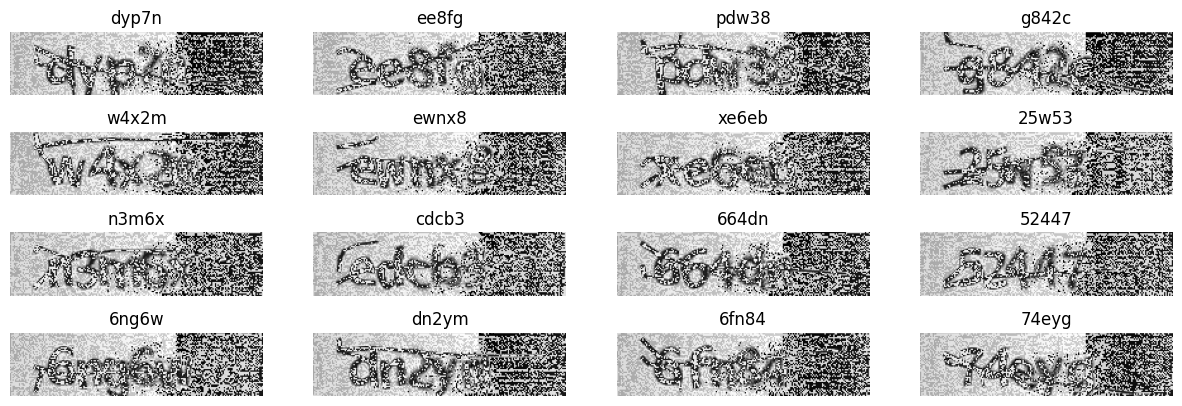

In [ ]:
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Crear un nuevo directorio para las imágenes adversariales
adversarial_dir = Path("./FGSM_01/")
adversarial_dir.mkdir(exist_ok=True)

# Guardar las imágenes adversariales sin el índice
for i, (img, label) in enumerate(zip(adversarial_images, adversarial_labels)):
    img = (img * 255).numpy().astype(np.uint8)
    if img.ndim == 2:  # Si la imagen es 2D (altura, ancho)
        img = np.expand_dims(img, axis=-1)  # Añadir la dimensión del canal
    # Rotar la imagen 90 grados en sentido antihorario y luego invertirla horizontalmente
    img = tf.image.rot90(img, k=3).numpy()  # k=3 para rotar 270 grados o -90 grados
    img = tf.image.flip_left_right(img).numpy()  # Invertir horizontalmente
    img = tf.image.encode_png(img).numpy()
    label_text = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    with open(adversarial_dir / f"{label_text}.png", "wb") as f:
        f.write(img)


# Visualizar ejemplos adversariales
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    img = (adversarial_images[i] * 255).numpy().astype(np.uint8)
    label = tf.strings.reduce_join(num_to_char(adversarial_labels[i])).numpy().decode("utf-8")
    if img.ndim == 2:  # Si la imagen es 2D (altura, ancho)
        img = np.expand_dims(img, axis=-1)  # Añadir la dimensión del canal
    # Rotar la imagen 90 grados en sentido antihorario y luego invertirla horizontalmente para la visualización
    img = tf.image.rot90(img, k=3).numpy()  # k=3 para rotar 270 grados o -90 grados
    img = tf.image.flip_left_right(img).numpy()  # Invertir horizontalmente
    ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")  # Mostrar la imagen sin transponer
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")
plt.show()


65/65 [==============================] - 1s 12ms/step
Tasa de Reconocimiento (Recognition Rate): 0.00%
Tasa de Error (Error Rate): 100.00%
Accuracy acumulativo por 1 caracteres: 5.38%
Accuracy acumulativo por 2 caracteres: 0.19%
Accuracy acumulativo por 3 caracteres: 0.00%
Accuracy acumulativo por 4 caracteres: 0.00%
Accuracy acumulativo por 5 caracteres: 0.00%
Tasa de Suceso del Ataque (Attack Success Rate): 100.00%
Verdadero: ktqgp - Predicción: ggg99
Verdadero: llhmn - Predicción: tggg9
Verdadero: qkrch - Predicción: ggg99
Verdadero: nhdbj - Predicción: tttg9
Verdadero: rdsbo - Predicción: qgggg
Verdadero: lrpsh - Predicción: tttg9
Verdadero: slfli - Predicción: gtgt9
Verdadero: berec - Predicción: tgg99
Verdadero: pcofs - Predicción: tgg99
Verdadero: jkjic - Predicción: tt999


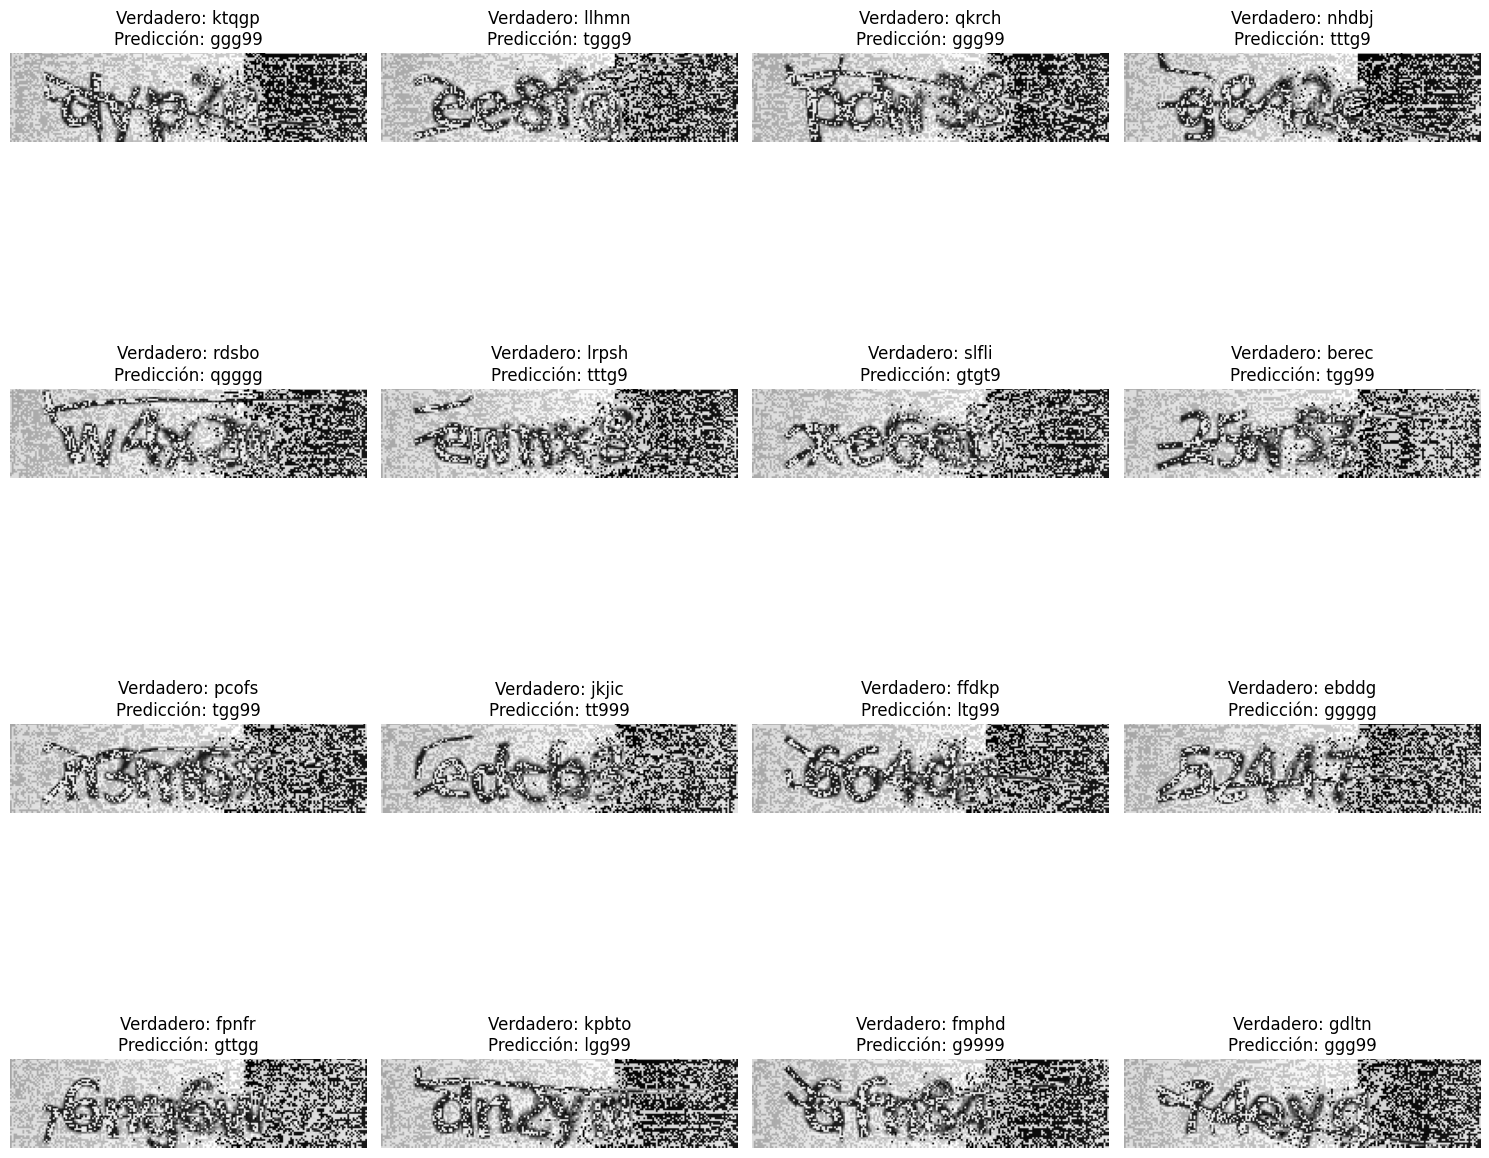

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Verifica que `num_to_char` esté bien definido
# Debe ser un mapeo correcto de índices a caracteres
def num_to_char(index):
    characters = "abcdefghijklmnopqrstuvwxyz0123456789"  # Ejemplo
    if index < len(characters):
        return characters[index]
    return ' '  # Reemplaza 'UNK' por espacio

# Función para preprocesar una imagen adversarial (girar 270 grados e invertir)
def preprocess_image(image):
    image = np.squeeze(image)
    if len(image.shape) == 2:  # Forma (height, width)
        image = np.expand_dims(image, axis=-1)  # Forma (height, width, 1)
    image = np.expand_dims(image, axis=0)  # Forma (1, height, width, channels)
    image = np.rot90(image, k=3, axes=(1, 2))
    image = np.flip(image, axis=2)
    return image

# Aplica el preprocesamiento a todas las imágenes
preprocessed_images = np.array([preprocess_image(img) for img in adversarial_images])

# Combina las imágenes preprocesadas de nuevo en un solo array
preprocessed_images = np.concatenate(preprocessed_images, axis=0)

# Función para decodificar las predicciones del modelo, limitando a 5 caracteres
def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for res in results:
        # Limita a 5 caracteres y reemplaza 'UNK' por espacio
        res = ''.join([num_to_char(idx) for idx in res[:5]])
        output_text.append(res)
    return output_text

# Evaluar el modelo en el conjunto de datos adversariales
predictions = prediction_model.predict(preprocessed_images, batch_size=batch_size)
decoded_predictions = decode_predictions(predictions)

# Obtener las etiquetas reales, limitadas a 5 caracteres
true_labels = [''.join([num_to_char(idx) for idx in label[:5]]) for label in adversarial_labels]

# Calcular la Tasa de Reconocimiento
correct_predictions = sum([1 for true, pred in zip(true_labels, decoded_predictions) if true == pred])
total_predictions = len(true_labels)
recognition_rate = correct_predictions / total_predictions
error_rate = 1 - recognition_rate

# Calcular el accuracy acumulativo por longitud de caracteres
cumulative_accuracy = {i: 0 for i in range(1, 6)}

for true, pred in zip(true_labels, decoded_predictions):
    for i in range(1, 6):
        if true[:i] == pred[:i]:
            cumulative_accuracy[i] += 1

cumulative_accuracy = {i: cumulative_accuracy[i] / total_predictions for i in cumulative_accuracy}

# Calcular la Tasa de Suceso del Ataque (Attack Success Rate)
attack_success_count = sum([1 for true, pred in zip(true_labels, decoded_predictions) if true != pred])
attack_success_rate = attack_success_count / total_predictions

# Mostrar los resultados
print(f"Tasa de Reconocimiento (Recognition Rate): {recognition_rate * 100:.2f}%")
print(f"Tasa de Error (Error Rate): {error_rate * 100:.2f}%")
for i in range(1, 6):
    print(f"Accuracy acumulativo por {i} caracteres: {cumulative_accuracy[i] * 100:.2f}%")
print(f"Tasa de Suceso del Ataque (Attack Success Rate): {attack_success_rate * 100:.2f}%")

# Mostrar algunas predicciones y las etiquetas verdaderas
for i in range(10):
    print(f"Verdadero: {true_labels[i]} - Predicción: {decoded_predictions[i]}")

# Visualizar ejemplos adversariales
_, ax = plt.subplots(4, 4, figsize=(15, 15))  # Ajustar el tamaño del gráfico
for i in range(16):
    img = (preprocessed_images[i] * 255).astype(np.uint8).squeeze()
    label = ''.join([num_to_char(idx) for idx in adversarial_labels[i][:5]])
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(f"Verdadero: {label}\nPredicción: {decoded_predictions[i]}")
    ax[i // 4, i % 4].axis("off")
plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
plt.show()